# IMPORTING THE DATASET AND DISPLAYING THE DATASET

In [2]:
import os
import numpy as np
import pandas as pd
train_df = pd.read_csv("train-balanced-sarcasm.csv")
train_df.head()


,label,comment,author,subreddit,score,ups,downs,date,created_utc,parent_comment
0,0,NC and NH.,Trumpbart,politics,2,-1,-1,2016-10,2016-10-16 23:55:23,"Yeah, I get that argument. At this point, I'd ..."
1,0,You do know west teams play against west teams...,Shbshb906,nba,-4,-1,-1,2016-11,2016-11-01 00:24:10,The blazers and Mavericks (The wests 5 and 6 s...
2,0,"They were underdogs earlier today, but since G...",Creepeth,nfl,3,3,0,2016-09,2016-09-22 21:45:37,They're favored to win.
3,0,"This meme isn't funny none of the ""new york ni...",icebrotha,BlackPeopleTwitter,-8,-1,-1,2016-10,2016-10-18 21:03:47,deadass don't kill my buzz
4,0,I could use one of those tools.,cush2push,MaddenUltimateTeam,6,-1,-1,2016-12,2016-12-30 17:00:13,Yep can confirm I saw the tool they use for th...


## PREPROCESSING

### CHECKING IF NULL VALUES PRESENT OR NOT

In [3]:
print(train_df.iloc[:, :-1].isnull().sum())
print(train_df.iloc[:,-1].isnull().sum())

label           0
comment        53
author          0
subreddit       0
score           0
ups             0
downs           0
date            0
created_utc     0
dtype: int64
0


### SOME COMMENTS ARE MISSING,SO WE DROP THOSE COMMENTS

In [4]:
train_df.dropna(subset=['comment'], inplace=True)

### THE 53 MISSING COMMENTS ARE REMOVED

In [5]:
print(train_df.iloc[:, :-1].isnull().sum())
print(train_df.iloc[:,-1].isnull().sum())

label          0
comment        0
author         0
subreddit      0
score          0
ups            0
downs          0
date           0
created_utc    0
dtype: int64
0


### HERE LABEL Determines whether it is sarcastic or not. 0->not sarcastic 1->sarcastic

In [6]:
train_df['label'].value_counts()

0    505405
1    505368
Name: label, dtype: int64

#### splitting the dataset: target variable(label) and independent variable(comment)

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
from matplotlib import pyplot as plt
train_texts, valid_texts, y_train, y_valid = \
        train_test_split(train_df['comment'], train_df['label'], random_state=17)

### Sorting the values

In [8]:
sub_df = train_df.groupby('subreddit')['label'].agg([np.size, np.mean, np.sum])
sub_df.sort_values(by='sum', ascending=False).head(10)

,size,mean,sum
subreddit,,,
AskReddit,65674,0.401453,26365
politics,39493,0.605348,23907
worldnews,26376,0.642516,16947
leagueoflegends,21034,0.542312,11407
pcmasterrace,18987,0.566651,10759
news,16891,0.603457,10193
funny,17939,0.451474,8099
pics,16152,0.484336,7823
todayilearned,14159,0.547567,7753


In [9]:
sub_df[sub_df['size'] > 1000].sort_values(by='mean', ascending=False).head(10)


,size,mean,sum
subreddit,,,
creepyPMs,5466,0.784303,4287
MensRights,3355,0.680775,2284
ShitRedditSays,1284,0.661994,850
worldnews,26376,0.642516,16947
Libertarian,2562,0.640125,1640
atheism,7377,0.639555,4718
Conservative,1881,0.639553,1203
TwoXChromosomes,1560,0.632692,987
fatlogic,2356,0.623090,1468


In [10]:
sub_df = train_df.groupby('author')['label'].agg([np.size, np.mean, np.sum])
sub_df[sub_df['size'] > 300].sort_values(by='mean', ascending=False).head(10)

,size,mean,sum
author,,,
NeonDisease,422,0.500000,211
ShyBiDude89,404,0.500000,202
ivsciguy,342,0.500000,171
mad-n-fla,318,0.500000,159
mindlessrabble,302,0.500000,151
pokemon_fetish,432,0.500000,216
Biffingston,845,0.499408,422


In [11]:
sub_df = train_df[train_df['score'] >= 0].groupby('score')['label'].agg([np.size, np.mean, np.sum])
sub_df[sub_df['size'] > 300].sort_values(by='mean', ascending=False).head(10)

,size,mean,sum
score,,,
0,58141,0.612752,35626
20,3096,0.561370,1738
34,1071,0.556489,596
26,1874,0.554429,1039
59,315,0.552381,174
18,3951,0.551759,2180
13,7277,0.546929,3980
17,4404,0.545867,2404
40,722,0.545706,394


In [12]:
sub_df = train_df[train_df['score'] < 0].groupby('score')['label'].agg([np.size, np.mean, np.sum])
sub_df[sub_df['size'] > 300].sort_values(by='mean', ascending=False).head(10)

,size,mean,sum
score,,,
-14,537,0.698324,375
-8,1852,0.696004,1289
-9,1503,0.691284,1039
-6,3088,0.688795,2127
-12,776,0.684278,531
-5,4134,0.678520,2805
-3,6736,0.676069,4554
-2,11924,0.675948,8060
-4,5436,0.673473,3661


# build bigrams, put a limit on maximal number of features
# and minimal word frequency

In [13]:
tf_idf = TfidfVectorizer(ngram_range=(1, 2), max_features=50000, min_df=2)

# multinomial logistic regression a.k.a softmax classifier

In [14]:
logit = LogisticRegression(C=1, n_jobs=4, solver='lbfgs', 
                           random_state=17, verbose=1)

# sklearn's pipeline

In [15]:
tfidf_logit_pipeline = Pipeline([('tf_idf', tf_idf), 
                                 ('logit', logit)])

### building the model (train_texts and y_train)

In [16]:
%%time
tfidf_logit_pipeline.fit(train_texts, y_train)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:  1.4min finished


Wall time: 4min 30s


Pipeline(steps=[('tf_idf',
                 TfidfVectorizer(max_features=50000, min_df=2,
                                 ngram_range=(1, 2))),
                ('logit',
                 LogisticRegression(C=1, n_jobs=4, random_state=17,
                                    verbose=1))])

### Validating the model (valid_texts)

In [17]:
%%time
valid_pre = tfidf_logit_pipeline.predict(valid_texts)

Wall time: 40.5 s


### checking the accuracy score with the predicted values and the actual values

In [18]:
accuracy_score(y_valid, valid_pre)

0.7207966948166558

### CHECKING THE PREDICTED VALUES

### CLASSIFICATION REPORT AND CONFUSION MATRIX

In [20]:
import itertools
import statsmodels.api as sm
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix,accuracy_score
print(classification_report(y_valid,valid_pre))
print(confusion_matrix(y_valid,valid_pre))

              precision    recall  f1-score   support

           0       0.71      0.75      0.73    126308
           1       0.74      0.69      0.71    126386

    accuracy                           0.72    252694
   macro avg       0.72      0.72      0.72    252694
weighted avg       0.72      0.72      0.72    252694

[[95128 31180]
 [39373 87013]]


### PLOTTING THE MATRIX

In [21]:
def plot_confusion_matrix(actual, predicted, classes,
                          normalize=False,
                          title='Confusion matrix', figsize=(7,7),
                          cmap=plt.cm.Blues, path_to_save_fig=None):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    import itertools
    from sklearn.metrics import confusion_matrix
    cm = confusion_matrix(actual, predicted).T
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    plt.figure(figsize=figsize)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Predicted label')
    plt.xlabel('True label')
    
    if path_to_save_fig:
        plt.savefig(path_to_save_fig, dpi=300, bbox_inches='tight')

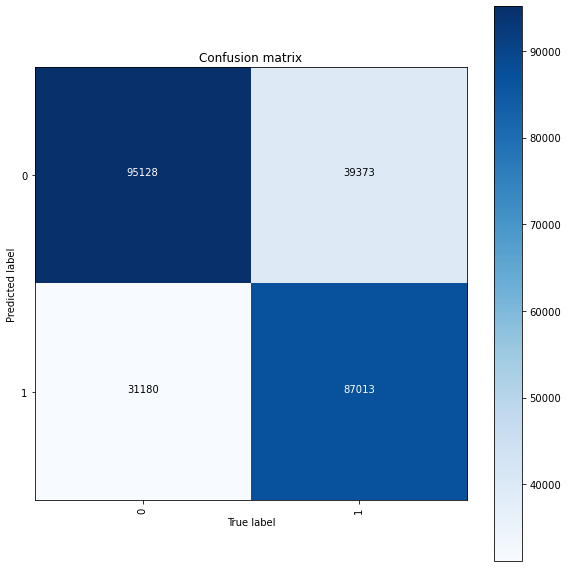

In [22]:
plot_confusion_matrix(y_valid, valid_pre, 
                      tfidf_logit_pipeline.named_steps['logit'].classes_, figsize=(8, 8))

In [23]:
import eli5
eli5.show_weights(estimator=tfidf_logit_pipeline.named_steps['logit'],
                  vec=tfidf_logit_pipeline.named_steps['tf_idf'])

Weight?,Feature
+9.547,yes because
+7.883,clearly
+7.375,obviously
+7.322,yeah because
+6.859,totally
+6.358,because
+5.936,how dare
+5.825,right because
+5.498,but thought
+5.222,duh


In [24]:
# import joblib
from joblib import dump

# dump the pipeline model
dump(tfidf_logit_pipeline, filename="lr.joblib")

['lr.joblib']

### Logistic Regression without pipeline

In [25]:
 ##TF-IDF where TF means term frequency, and IDF means Inverse Document frequency.

In [26]:
from sklearn.feature_extraction.text import TfidfVectorizer
text_transformer = TfidfVectorizer(ngram_range=(1, 2), max_features=60000, min_df=2)

In [27]:
X_train_text = text_transformer.fit_transform(train_texts)
X_test_text = text_transformer.transform(valid_texts)

In [28]:
logit = LogisticRegression(n_jobs=4, solver='sag', 
                           random_state=17, verbose=1)
logit.fit(X_train_text,y_train)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.


convergence after 25 epochs took 75 seconds


[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:  1.3min finished


LogisticRegression(n_jobs=4, random_state=17, solver='sag', verbose=1)

In [29]:
valid_pred = logit.predict(X_test_text)

In [30]:
accuracy_score(y_valid, valid_pred)

0.7217860337008397

## NB algorithm 

In [31]:
# fit the training dataset on the NB classifier
from sklearn.naive_bayes import MultinomialNB
Naive = MultinomialNB()
Naive.fit(X_train_text,y_train)
# predict the labels on validation dataset
predictions_NB = Naive.predict(X_test_text)
# Use accuracy_score function to get the accuracy
print("Naive Bayes Accuracy Score -> ",accuracy_score( y_valid,predictions_NB)*100)

Naive Bayes Accuracy Score ->  70.5869549732087


## Using pickle to serialize the model logit and the tfidf 

In [32]:
import pickle
# Saving model to disk
pickle.dump(logit, open('lrmodel.pkl','wb'))
# Saving model to disk
pickle.dump(text_transformer, open('transformer.pkl','wb'))